In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os, sys
from tqdm import tqdm
from datetime import datetime

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable

from sklearn.decomposition import PCA


from autoencoder import Autoencoder
from solver import train_vali_all_epochs, dev_train_vali_all_epochs, test

In [3]:
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

batch_size = 128
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=6)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=6)

In [4]:
run_id = datetime.today().strftime("%Y-%m-%d_%H-%M-%S")
save_path = os.getenv("HOME") + '/sparsify_models/AE/MNIST/' +run_id +'/'
print(save_path)

/home/david/sparsify_models/AE/MNIST/2024-10-28_15-10-55/


Train Epoch: 0 [44928/60000 (100%)]	Loss: 0.000206: 100%|██████████| 469/469 [00:01<00:00, 241.16it/s]


====> Epoch: 0 Average loss: 0.0356


/home/david/Documents/UNI_LOCAL/PyTorch/MarkosCode/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0197
Directory created: /home/david/sparsify_models/AE/MNIST/2024-10-28_15-10-55/Static/
Weights saved.
All train losses saved.


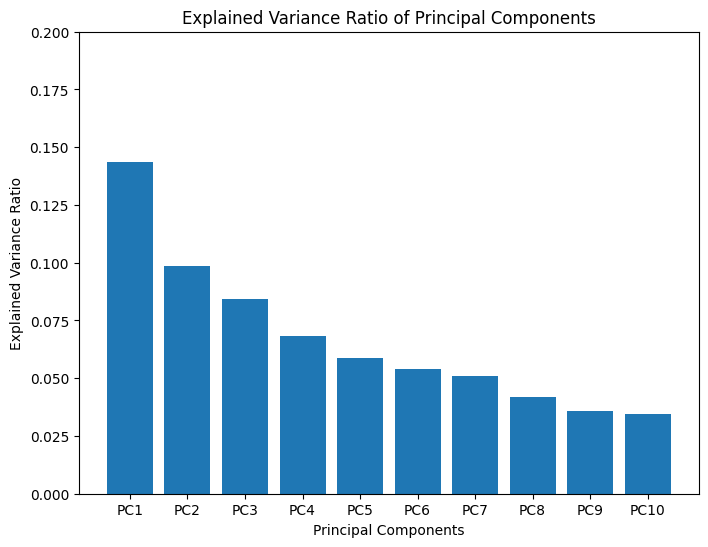

Train Epoch: 0 [44928/60000 (100%)]	Loss: 0.000179: 100%|██████████| 469/469 [00:01<00:00, 251.34it/s]


====> Epoch: 0 Average loss: 0.0182


/home/david/Documents/UNI_LOCAL/PyTorch/MarkosCode/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0170
Weights saved.
All train losses saved.


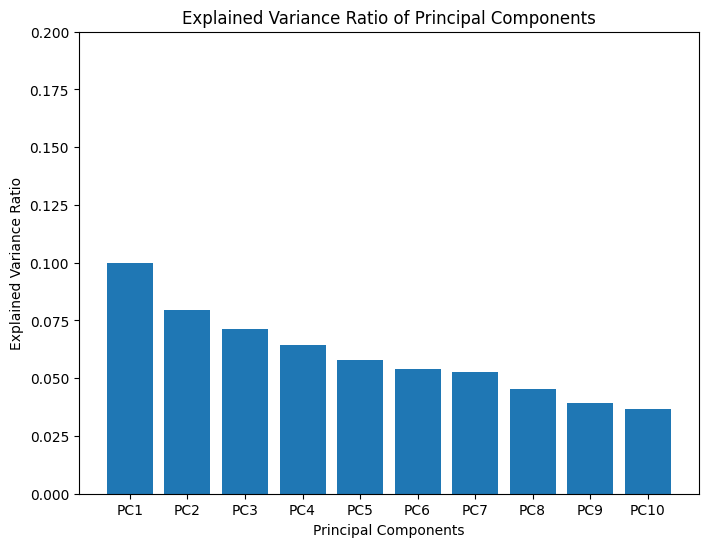

Train Epoch: 0 [44928/60000 (100%)]	Loss: 0.000183: 100%|██████████| 469/469 [00:01<00:00, 249.47it/s]

====> Epoch: 0 Average loss: 0.0174



/home/david/Documents/UNI_LOCAL/PyTorch/MarkosCode/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0169
Weights saved.
All train losses saved.


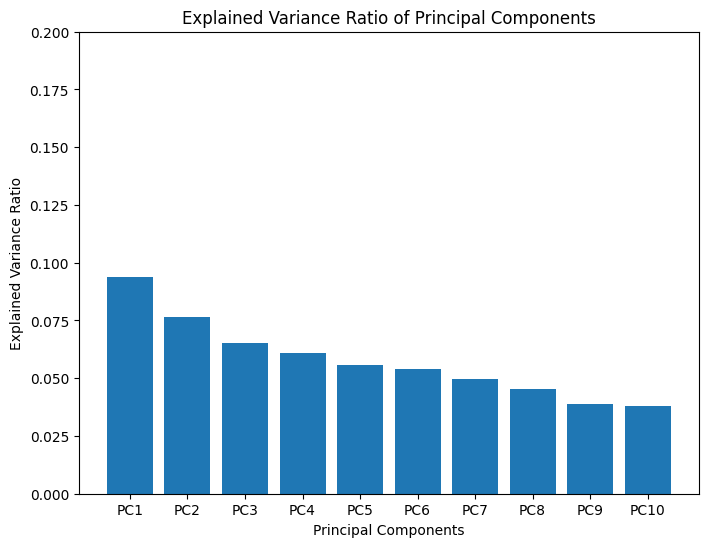

In [5]:
model = Autoencoder(n_input=784, n_hidden_ls=[512, 128, 32], n_layers=3)
optimizer = torch.optim.SGD(model.parameters(), lr=0.5, momentum=0.99)
device = torch.device('cuda')

explained_variance_ratios = []
latent_matrices = []

for i in range(3):
    model.train()
    train_losses, vali_losses = train_vali_all_epochs(model, train_loader, test_loader, optimizer, n_epochs=1, device=device, save_path=save_path+'Static/')

    latent_list = []
    model.eval()

    # Loop through validation data
    with torch.no_grad():  # Gradients not calculated
        for batch_idx, (data, target) in enumerate(test_loader):
            # Convert to a PyTorch variable
            data = Variable(data).to('cuda')

            # Flatten the input data into a 2D tensor [batch_size, num_features]
            batch_size = data.size(0)
            input = data.view(batch_size, -1).to('cuda')

            encoded = model(input)[0]

            latent_list.append(encoded.cpu().numpy())

    latent_matrix = np.concatenate(latent_list)

    pca = PCA(n_components=10)
    pca.fit(latent_matrix)

    explained_variance_ratios.append(pca.explained_variance_ratio_)
    latent_matrices.append(pca.components_)


    x_labels = [f'PC{i+1}' for i in range(10)]

    plt.figure(figsize=(8, 6))
    plt.bar(x_labels, pca.explained_variance_ratio_)
    plt.ylim(0, 0.2)
    plt.xlabel('Principal Components')
    plt.ylabel('Explained Variance Ratio')
    plt.title('Explained Variance Ratio of Principal Components')
    plt.show()

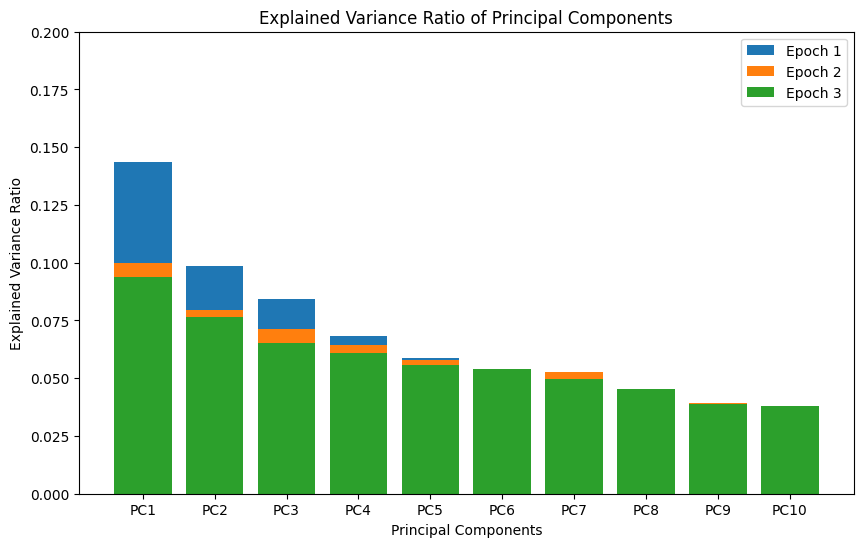

Epoch 1 sum of EVRs:  0.67109466
Epoch 2 sum of EVRs:  0.6005888
Epoch 3 sum of EVRs:  0.5777624


In [6]:

explained_variance_ratio1 = explained_variance_ratios[0]
explained_variance_ratio2 = explained_variance_ratios[1]
explained_variance_ratio3 = explained_variance_ratios[2]

x_labels = [f'PC{i+1}' for i in range(10)]
x = np.arange(len(x_labels))

plt.figure(figsize=(10, 6))

plt.bar(x, explained_variance_ratio1, label='Epoch 1')
plt.bar(x, explained_variance_ratio2, label='Epoch 2')
plt.bar(x, explained_variance_ratio3, label='Epoch 3')

plt.ylim(0, 0.2)
plt.xticks(x, x_labels)
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio of Principal Components')
plt.legend()
plt.show()

print('Epoch 1 sum of EVRs: ', sum(explained_variance_ratio1))
print('Epoch 2 sum of EVRs: ', sum(explained_variance_ratio2))
print('Epoch 3 sum of EVRs: ', sum(explained_variance_ratio3))


In [7]:
# cos(theta) = (pc1_epoch1 · pc1_epoch2) / (||pc1_epoch1|| * ||pc1_epoch2||)
def cosine_angle_between_pcs(pc_a, pc_b):
    numerator = np.dot(pc_a, pc_b)
    denominator = np.linalg.norm(pc_a) * np.linalg.norm(pc_b)

    cos_value = numerator / denominator

    angle = np.arccos(cos_value) * 180 / np.pi
    
    return angle

# Ensure correct principal components are selected
pc_a = latent_matrices[0][3]
pc_b = latent_matrices[1][3]

for i in range(10):
    for j in range(10):
        for x in [(0, 1), (1, 2)]:
            angle = cosine_angle_between_pcs(latent_matrices[x[0]][i], latent_matrices[x[1]][j])
            if angle < 10:
                print(f'PC{i} and PC{j} between epochs {x[0]} and {x[1]}: {angle}')

PC0 and PC0 between epochs 1 and 2: 6.690553188323975
